In [1]:
import sys
import os

root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root)
print(os.getcwd())

/Users/kashyap/Library/CloudStorage/ProtonDrive-kashyap.suthar07@pm.me-folder/Capstone_Project/models


In [2]:
from utils.preprocessing import load_and_trasnform, preprocessing_data
from utils.save_metrics import save_metrics

import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import matplotlib.pyplot as plt
import seaborn as sns

print("All imports successful!")

All imports successful!


In [3]:
X, y = load_and_trasnform("../data/train.csv")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)


X_train: (1119, 80)
X_val  : (280, 80)


In [4]:
preprocessor = preprocessing_data(X_train)

In [5]:
base_ridge = Ridge(alpha=12.0)
base_lasso = Lasso(alpha=0.2, max_iter=50000)
base_elastic_net = ElasticNet(alpha=0.5, l1_ratio=0.1, max_iter=50000)
base_svr = SVR(kernel='rbf', C=80.0, epsilon=0.1, gamma='scale')


In [6]:
estimators = [
    ("elastic_net", base_elastic_net),
    ("ridge", base_ridge),
    ("lasso", base_lasso),
    ("svr", base_svr),
]


In [7]:
meta_rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=45,
    max_features='sqrt',
)


In [8]:
stack_model =  StackingRegressor(
    estimators=estimators,
    final_estimator=meta_rf,
    #cv=2,
    passthrough=False,
)

In [9]:
stack_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("stacked_model", stack_model),
])


In [10]:
stack_pipe.fit(X_train, y_train)
y_val_pred = stack_pipe.predict(X_val)

In [11]:
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print("Stacking Regressor:")
print("  MSE :", mse)
print("  RMSE:", rmse)
print("  MAE :", mae)
print("  R2  :", r2)


Stacking Regressor:
  MSE : 269727396.9362322
  RMSE: 16423.379583271897
  MAE : 11489.710375
  R2  : 0.915201860645951


In [12]:
save_metrics("Stacking Regression", mse, rmse, mae, r2)

Saved metrics to /Users/kashyap/Library/CloudStorage/ProtonDrive-kashyap.suthar07@pm.me-folder/Capstone_Project/utils/../metrics/stacking_regression.json


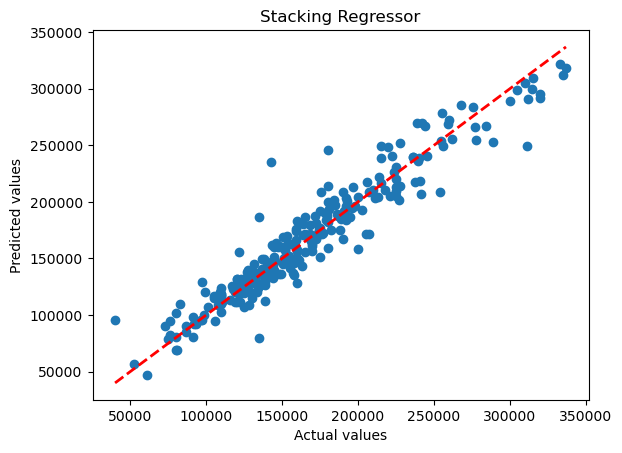

In [13]:
plt.figure()
plt.scatter(y_val, y_val_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Stacking Regressor")
plt.show()

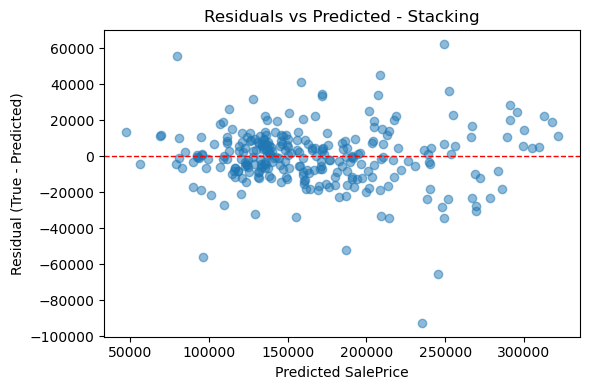

In [14]:
residuals = y_val - y_val_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals vs Predicted - Stacking")
plt.tight_layout()
plt.show()